# Shape

Folgende Zelle importiert alle benötigten Python Libraries

In [1]:
%matplotlib notebook
import fiona
from ortools.linear_solver import pywraplp
from shapely.geometry.geo import shape
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In der nächsten Zelle werden alle benötigten Konstanten gesetzt. Für dieses Beispiel werden die Zürcher Stadt Kreise verwendet. Diese wurden von Openstreetmap exportiert. Jeder Kreis wird mit 0-11 nummeriert (Entspricht nicht den effektiven Kreisnummern, sondern der Position im Datenfile).

In [2]:
# Weight between max benefit and min perimeter
w = 0.8

# Project budget treshold
Y = 5000

costs = {}
costs[0] = 1254
costs[1] = 1354
costs[2] = 3453
costs[3] = 143
costs[4] = 1541
costs[5] = 634
costs[6] = 6332
costs[7] = 8563
costs[8] = 6356
costs[9] = 955
costs[10] = 1235
costs[11] = 743

sum_costs = sum(costs.values())
print("Tot costs: {}".format(sum_costs))

benefits = {}
benefits[0] = 10000
benefits[1] = 30000
benefits[2] = 60000
benefits[3] = 30000
benefits[4] = 40000
benefits[5] = 50000
benefits[6] = 60000
benefits[7] = 30000
benefits[8] = 50000
benefits[9] = 60000
benefits[10] = 80000
benefits[11] = 90000

sum_benefit = sum(benefits.values())
print("Tot benefit: {}".format(sum_benefit))


Tot costs: 32563
Tot benefit: 590000


In folgender Zelle werden die Kreis Geometrien aus dem File "zh_kreise_lv03.geojson" eingelesen. 

In [3]:
# Read districts
districts = {}
with fiona.open("zh_kreise_lv03.geojson") as src:
    crs = src.meta['crs']
    c = 0
    for f in src:
        geom = shape(f['geometry'])
        if geom.geom_type == 'Polygon':
            districts[c] = geom
            c += 1

Für jeden Kreis berechnen wir nun den mit einem Nachbarkreis geteilten, bzw. mit keinem Kreis, geteilten Perimeter.

In [4]:
shared_perimeter = {}
# Get borders
for i in range(len(districts)):
    for j in range(len(districts)):
        if not i == j and districts[i].intersects(districts[j]):
            shared_perimeter[(i ,j)] = districts[i].intersection(districts[j]).length            

not_shared_perimeter = {}
for i in range(len(districts)):
    geoms = []
    for j in range(len(districts)):
        if not i == j:
            geoms.append(districts[j])
    geom = cascaded_union(geoms)
    perimeter = districts[i].exterior
    not_shared_perimeter[i] = perimeter.difference(geom).length

In folgender Zelle wird mit der Library ortools das Shape Optimierungsmodell erstellt

In [5]:
solver = pywraplp.Solver('simple_mip_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

var_x = {}
for i in range(len(districts)):
    var_x[i] =  solver.IntVar(0.0, 1.0, 'x{}'.format(i))

var_ep = {}
var_em = {}
for i in range(len(districts)):
    for j in range(len(districts)):
        if (i, j) in shared_perimeter:
            var_ep[(i, j)] =  solver.IntVar(0.0, 1.0, 'e_p_{}_{}'.format(i, j))
            var_em[(i, j)] =  solver.IntVar(0.0, 1.0, 'e_m_{}_{}'.format(i, j))

# Create objective function
objective = solver.Objective()

# perimeter between shapes
for i in range(len(districts)):
    for j in range(len(districts)):
        if (i, j) in shared_perimeter:
            objective.SetCoefficient(var_ep[(i, j)], shared_perimeter[(i ,j)] * w * -1)
            objective.SetCoefficient(var_em[(i, j)], shared_perimeter[(i ,j)] * w * -1)

# perimter not shared 
for i in range(len(districts)):
    if not_shared_perimeter[i] > 0:
        objective.SetCoefficient(var_x[i], not_shared_perimeter[i] * w * -1)
    
# utility
for i in range(len(districts)):
    objective.SetCoefficient(var_x[i], benefits[i] * (1 - w))
    
objective.SetMaximization()


# Constraints:

# Limit  costs
solver.Add(sum([costs[i] * var_x[i] for i in range(len(districts))]) <= Y)

# E+. E- constraints
for i in range(len(districts)):
    for j in range(len(districts)):
        if (i, j) in shared_perimeter:
            solver.Add(var_x[i] - var_x[j] - var_ep[(i, j)] + var_em[(i, j)] == 0)

Nun wird das Optimierungsmodell gelöst:

In [6]:
result_status = solver.Solve()
# The problem has an optimal solution.
assert result_status == pywraplp.Solver.OPTIMAL

# The solution looks legit (when using solvers others than
# GLOP_LINEAR_PROGRAMMING, verifying the solution is highly recommended!).
assert solver.VerifySolution(1e-7, True)

print('Solution:')
print('Objective value =', round(solver.Objective().Value(), 2))

print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations' % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())


Solution:
Objective value = 38224.92

Advanced usage:
Problem solved in 25.000000 milliseconds
Problem solved in 0 iterations
Problem solved in 0 branch-and-bound nodes


Zum Schluss analysieren wird das Resultat

Geometry perimeter: 33420.0
Model perimeter: 33420.0
Model benefit: 280000.0


<IPython.core.display.Javascript object>


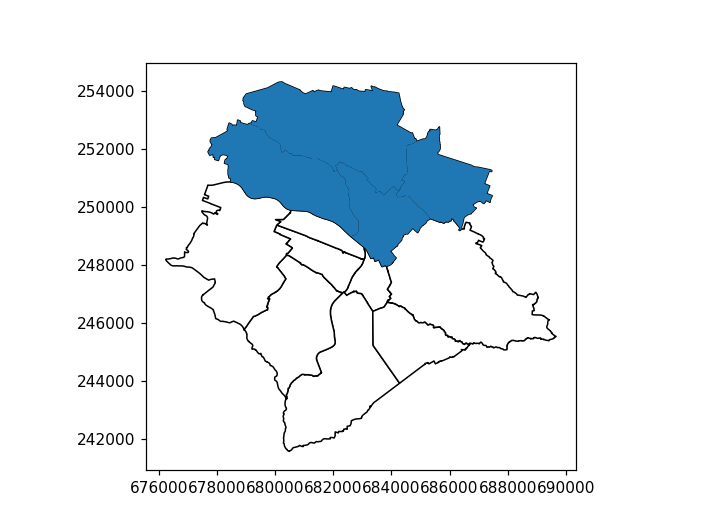

In [7]:
data = []
selected_geoms = []
for i in range(len(districts)):
    if var_x[i].solution_value() == 1.0:
        data.append({ "cost": costs[i],
                               "benefit": benefits[i],
                               "geometry": districts[i]})
        selected_geoms.append(districts[i])

union = cascaded_union(selected_geoms)
print("Geometry perimeter: {}".format(round(union.length, 2)))

model_perimeter = 0.0
# perimeter between shapes
for i in range(len(districts)):
    for j in range(len(districts)):
        if (i, j) in shared_perimeter:
            model_perimeter += (var_ep[(i, j)].solution_value() + var_em[(i, j)].solution_value()) * shared_perimeter[(i ,j)] * 0.5

# perimter not shared 
for i in range(len(districts)):
    if not_shared_perimeter[i] > 0:
        model_perimeter += var_x[i].solution_value() * not_shared_perimeter[i]
print("Model perimeter: {}".format(round(model_perimeter, 2)))

model_benefit = 0.0
for i in range(len(districts)):
    if var_x[i].solution_value() == 1.0:
        model_benefit += benefits[i]

print("Model benefit: {}".format(model_benefit))

fig, ax = plt.subplots()
# Geopandas dataframe for all geometries
all_districts = gpd.read_file("zh_kreise_lv03.geojson")
all_districts.plot(ax=ax, color='white', edgecolor='black')

df = pd.DataFrame(data)
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=selected_geoms)

gdf.plot(ax=ax)
plt.show()